In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

from tqdm import tqdm

import matplotlib.pyplot as plt

In [5]:
dataset_train = FashionMNIST(root="../datasets", train=True, download=False, transform=ToTensor())
dataset_test = FashionMNIST(root="../datasets", train=False, download=False, transform=ToTensor())

RuntimeError: Dataset not found. You can use download=True to download it

In [6]:
BS = 32
dataloader_train = DataLoader(dataset_train, batch_size=BS, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BS, shuffle=True)

NameError: name 'dataset_train' is not defined

In [243]:
class NiN_Block(nn.Module):
    def __init__(self, inc, outc, ks, stride, padding):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=inc, out_channels=outc, kernel_size=ks, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=outc, out_channels=outc, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),            
            nn.Conv2d(in_channels=outc, out_channels=outc, kernel_size=1, stride=1, padding=0),
            nn.ReLU()        
        )
    def forward(self, x):
        return self.layer_stack(x)

class NiN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            NiN_Block(1, 24, 1, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            NiN_Block(24, 48, 1, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),
            NiN_Block(48, 10, 1, 1, 1),
            #nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_features=10*10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        )   
    def forward(self, x):
        return self.layer_stack(x)

In [244]:
device = torch.device("cuda")

In [245]:
model = NiN()
print(model(torch.rand((1,1,28,28))).shape)
model = model.to(device)

torch.Size([1, 10])


In [ ]:
model.train()

n_epochs = 5

b_epochs = 60_000/BS

loss_fn = nn.NLLLoss()

optim = torch.optim.SGD(params=model.parameters(), lr=0.01)

losses = []
accs = []

for e in tqdm(range(n_epochs)):
    
    for b, (x, y) in enumerate(dataloader_train):
        
        optim.zero_grad()
        
        pred = model(x.to(device))
        
        loss = loss_fn(pred, y.to(device))
        losses.append(loss.detach().cpu().item())
        
        acc = (pred.detach().cpu().argmax(dim=1)==y).sum()/BS
        accs.append(acc.detach().cpu().item())
        
        loss.backward()
        
        optim.step()
                    
        if b % 150 == 0: print(e, b, losses[len(losses)-1]/BS, acc.item())

  0%|                                                | 0/5 [00:00<?, ?it/s]

0 0 0.07132118195295334 0.1875
0 150 0.07218334078788757 0.15625
0 300 0.07197755575180054 0.125
0 450 0.07169632613658905 0.0625
0 600 0.0719577744603157 0.09375
0 750 0.07202992588281631 0.125
0 900 0.0718400701880455 0.21875
0 1050 0.07209646701812744 0.03125
0 1200 0.07200504094362259 0.0625
0 1350 0.0720108151435852 0.03125
0 1500 0.07208994030952454 0.0625
0 1650 0.07203110307455063 0.09375
0 1800 0.07189351320266724 0.1875


 20%|████████                                | 1/5 [00:08<00:34,  8.69s/it]

1 0 0.0720863938331604 0.15625
1 150 0.07187758386135101 0.125
1 300 0.07194094359874725 0.1875
1 450 0.07194900512695312 0.09375
1 600 0.07199135422706604 0.0625


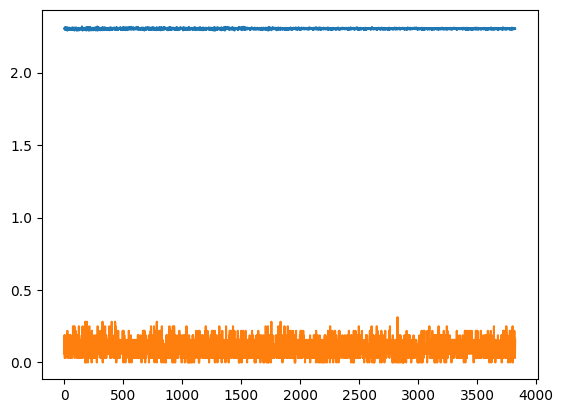

In [238]:
plt.plot(losses)
plt.plot(accs)

In [239]:
model.eval()
score = 0
for x, y in dataloader_test:
    score += (model(x.to(device)).argmax().detach().cpu()==y).sum()
score

tensor(34)